In [1]:
# importación de librerias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
import tensorflow as tf

# Verifica los dispositivos disponibles
print("Dispositivos disponibles:")
for device in tf.config.list_physical_devices():
    print(device)
    
# Verifica si se está utilizando Metal (para chips de apple silicon)
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
else:
    print("GPU no está disponible.")

# Configuración para limitar el crecimiento de memoria
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configura TensorFlow para que use toda la memoria de GPU disponible
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Dispositivos disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU está disponible.


In [4]:
!curl -L -o brain_tumor_dataset.zip https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/refs/heads/master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6634k    0 6634k    0     0  2001k      0 --:--:--  0:00:03 --:--:-- 2850k^C


In [ ]:
import zipfile
import os

# Rutas
zip_path = 'brain_tumor_dataset.zip'
extract_to = 'data'

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('models'):
    os.makedirs('models')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verificar los archivos extraídos
extracted_files = os.listdir(extract_to)
print(extracted_files)


In [3]:
# rutas
TEST_PATH = './data/Brain-Tumor-Classification-DataSet-master/Testing'
TRAIN_PATH = './data/Brain-Tumor-Classification-DataSet-master/Training'
# tamaño de imagen
IMG_SIZE = (224,224)
#  categorias
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

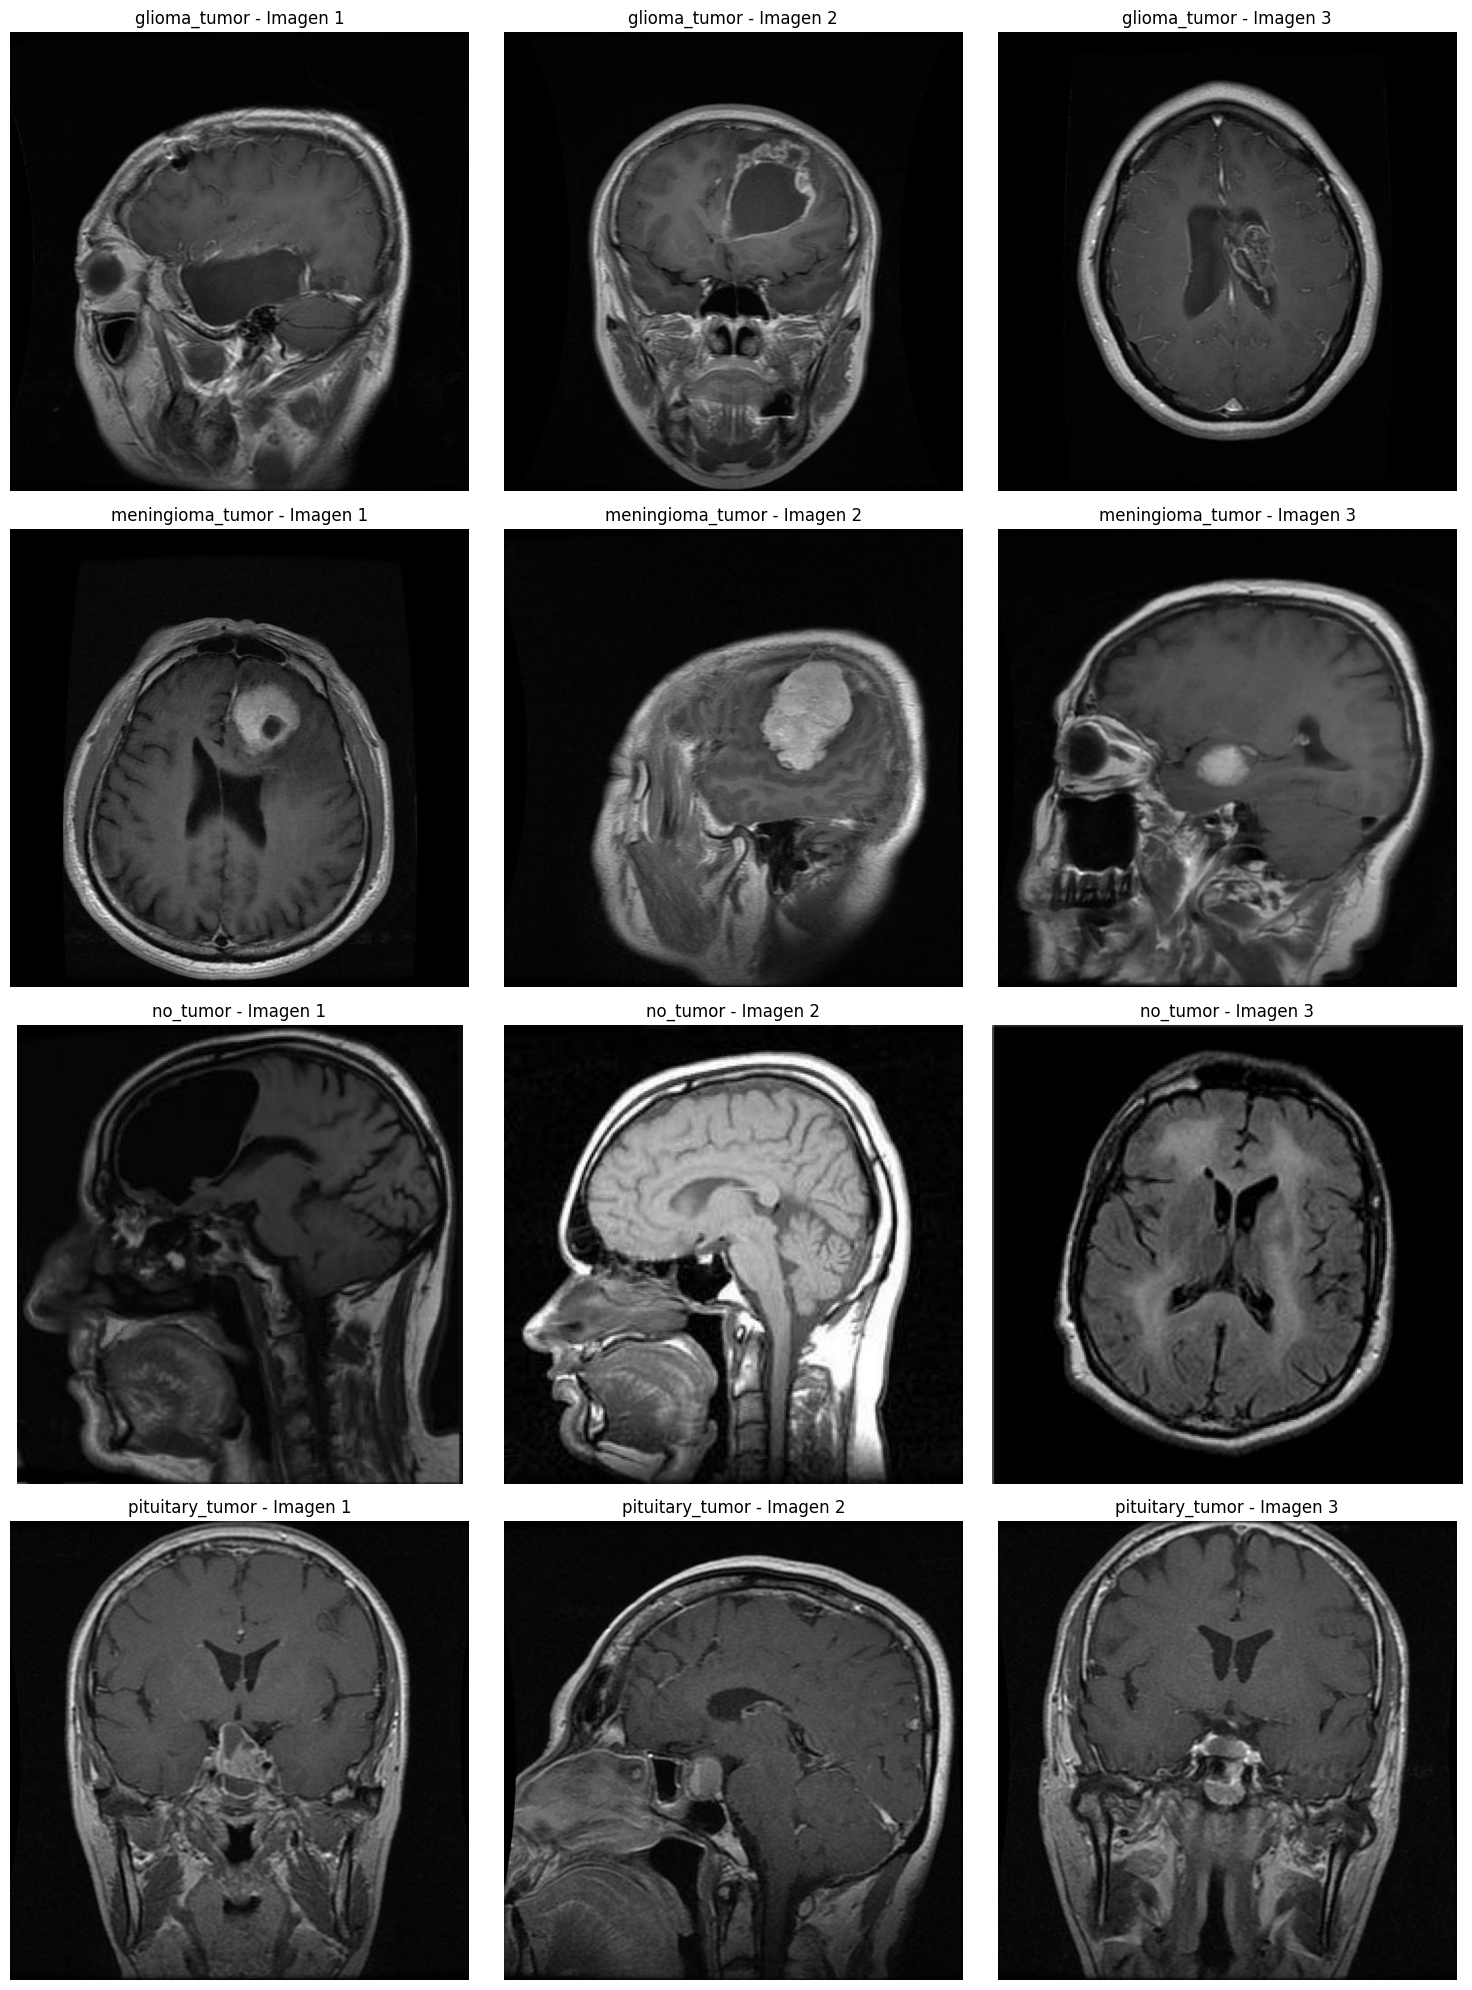

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

# Definir la función para mostrar las imágenes en una grilla
def show_images_in_grid(image_paths, titles, images_per_row=3):
    num_images = len(image_paths)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    plt.figure(figsize=(15, 5 * num_rows))
    
    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para matplotlib
        
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Recopilar las rutas de las imágenes y los títulos
image_paths = []
titles = []

for category in CATEGORIES:
    image_files = os.listdir(os.path.join(TRAIN_PATH, category))
    num_images_to_show = min(len(image_files), 3)  # Mostrar hasta 3 imágenes por categoría
    
    for i in range(num_images_to_show):
        image_path = os.path.join(TRAIN_PATH, category, image_files[i])
        image_paths.append(image_path)
        titles.append(f"{category} - Imagen {i + 1}")

# Mostrar las imágenes en una grilla
show_images_in_grid(image_paths, titles, images_per_row=3)


### Funciones a utilizar

In [5]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

def create_dataset(data_path, categories, img_size):
    """Genera un dataset a partir de imágenes en un directorio dado."""
    data = []

    for category in categories:
        path = os.path.join(data_path, category)
        class_id = categories.index(category)
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path, img)
            img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img_array is not None:
                resized_array = cv2.resize(img_array, img_size)  # (ancho, alto)
                data.append([resized_array, class_id])
            else:
                print(f"Error al cargar la imagen {img_path}")

    random.shuffle(data)

    # Separar imágenes y etiquetas
    X = np.array([item[0] for item in data])
    y = np.array([item[1] for item in data])
    
    return X, y

In [ ]:
!pip install seaborn

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Recall, Precision
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,  Flatten, Input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
import seaborn as sns
from sklearn.preprocessing import label_binarize

def load_pretrained_model(model_path):
    """Carga un modelo preentrenado desde un archivo .keras."""
    return load_model(model_path)

def display_images(images, labels, class_names, num_images=9):
    """Displays a grid of images with their labels."""
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        # Ensure labels are integers for indexing
        label_index = int(labels[i]) if isinstance(labels[i], (np.float32, np.float64)) else labels[i]

        plt.title(class_names[label_index])
    plt.tight_layout()
    plt.show()

def visualize_images(generator, class_names, num_images=9):
    """Visualiza imágenes de un generador."""
    images, labels = next(generator)
    
    # Normalize images to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    
    # Convert labels to integers if necessary
    labels = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    display_images(images, labels, class_names, num_images=num_images)
    

def create_data_generators(X, y, batch_size=32, value=0.1, img_size=(224, 224), augmentation=False, save_augmented=False, augmented_save_dir="augmented_images", categories=None):
    """Crea generadores de datos a partir de arrays en memoria."""
    
    if augmentation:
        # Configuración de aumento de datos
        datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=value,
            height_shift_range=value,
            shear_range=value,
            zoom_range=0,
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.8, 2]
        )
    else:
        datagen = ImageDataGenerator()

    # Crear generador de datos
    data_generator = datagen.flow(X, y, batch_size=batch_size)

    if save_augmented:
        ensure_directory_exists(augmented_save_dir)

        steps_per_epoch = len(data_generator)
        for i in range(steps_per_epoch):
            batch_images, batch_labels = next(data_generator)
            for j, image in enumerate(batch_images):
                img = array_to_img(image)
                img = img.resize(img_size)  # Asegurarse de que la imagen esté en el tamaño deseado
                category = categories[int(batch_labels[j])]
                category_dir = os.path.join(augmented_save_dir, category)
                ensure_directory_exists(category_dir)
                img.save(os.path.join(category_dir, f"aug_{i}_{j}.png"))

    return data_generator



def compile_model(model, optimizer_instance, learning_rate):
    # Ajusta el learning rate del optimizador
    optimizer_instance.learning_rate = learning_rate
    
    # Compila el modelo con el optimizador y el learning rate proporcionados
    model.compile(
        optimizer=optimizer_instance,
        loss='sparse_categorical_crossentropy',  
        metrics=['accuracy', Precision(), Recall()]
    )
    model.summary()

def save_model(model, save_path):
    """Guarda el modelo reentrenado en un archivo .h5."""
    model.save(save_path)

def plot_training_history(history, model_name):
    """Genera gráficos de precisión y pérdida del entrenamiento y añade métricas como texto con el nombre del modelo en el título."""
    sns.set(style="whitegrid")
    
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=acc, marker='o', label='Precisión en entrenamiento', color='b')
    sns.lineplot(x=epochs, y=val_acc, marker='o', label='Precisión en validación', color='r')
    plt.title(f'Precisión del entrenamiento y validación - {model_name}', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Precisión', fontsize=14)
    plt.legend()
    plt.text(epochs[-1], acc[-1], f'{acc[-1]:.4f}', ha='center', va='bottom', color='b')
    plt.text(epochs[-1], val_acc[-1], f'{val_acc[-1]:.4f}', ha='center', va='bottom', color='r')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=loss, marker='o', label='Pérdida en entrenamiento', color='b')
    sns.lineplot(x=epochs, y=val_loss, marker='o', label='Pérdida en validación', color='r')
    plt.title(f'Pérdida del entrenamiento y validación - {model_name}', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Pérdida', fontsize=14)
    plt.legend()
    plt.text(epochs[-1], loss[-1], f'{loss[-1]:.4f}', ha='center', va='bottom', color='b')
    plt.text(epochs[-1], val_loss[-1], f'{val_loss[-1]:.4f}', ha='center', va='bottom', color='r')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def plot_precision_recall(y_true, y_pred, classes):
    y_true_binarized = label_binarize(y_true, classes=range(len(classes)))
    y_pred_binarized = label_binarize(y_pred, classes=range(len(classes)))
    
    plt.figure(figsize=(10, 8))
    
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
        plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve of class {classes[i]}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


def set_fine_tuning_layers(model, freeze_layers):
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-freeze_layers:]:
        layer.trainable = True
    return model


def create_model(base_model_class, num_classes, input_shape=(224, 224, 3), weights='imagenet'):
    base_model = base_model_class(weights=weights, include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)

    return model


def train_model(model, train_generator, validation_generator, epochs=10, callbacks=None, learning_rate=0.001, fine_tuning=True, fine_tuning_layers=3, optimizer_instance=None):
    if fine_tuning:
        model = set_fine_tuning_layers(model, fine_tuning_layers)
    
    if optimizer_instance is None:
        optimizer_instance = Adam(learning_rate=0.001)
    
    compile_model(model, learning_rate, optimizer_instance)

    # Verify shapes of data and labels
    for data_batch, labels_batch in train_generator:
        print("Data batch shape:", data_batch.shape)
        print("Labels batch shape:", labels_batch.shape)
        break

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    return history


def compile_model(model, learning_rate, optimizer_instance=None):
    if optimizer_instance is None:
        optimizer_instance = Adam(learning_rate=learning_rate)

    optimizer_instance.learning_rate = learning_rate

    model.compile(optimizer=optimizer_instance,
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])
    model.summary()


def load_augmented_images(directory, categories, img_size):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                if img_array is not None and img_array.size > 0:
                    resized_array = cv2.resize(img_array, (img_size[0], img_size[1]))
                    images.append(resized_array)
                    labels.append(class_num)
                else:
                    print(f"Error: No se pudo cargar la imagen {img}")
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


def ensure_directory_exists(directory):
    """Crea el directorio si no existe."""
    if not os.path.exists(directory):
        os.makedirs(directory)

In [11]:
import os

def check_data_dir(dir_path):
    """Verifica si el directorio contiene subdirectorios con datos."""
    if not os.path.exists(dir_path):
        print(f"El directorio {dir_path} no existe.")
        return False
    
    subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    if not subdirs:
        print(f"El directorio {dir_path} no contiene subdirectorios.")
        return False

    print(f"El directorio {dir_path} contiene las siguientes subcarpetas:")
    for subdir in subdirs:
        print(f" - {subdir}")
    return True

check_data_dir(TRAIN_PATH)
check_data_dir(TEST_PATH)


El directorio ./data/Brain-Tumor-Classification-DataSet-master/Training contiene las siguientes subcarpetas:
 - no_tumor
 - meningioma_tumor
 - glioma_tumor
 - pituitary_tumor
El directorio ./data/Brain-Tumor-Classification-DataSet-master/Testing contiene las siguientes subcarpetas:
 - no_tumor
 - meningioma_tumor
 - glioma_tumor
 - pituitary_tumor


True

### Preparación de los datos

In [12]:
batch_size=32
learning_rate=0.001
augmentation_value=0.2
epochs=50
state_seed = 74

In [8]:
# Crear conjuntos de datos
X_train, y_train = create_dataset(TRAIN_PATH, CATEGORIES, IMG_SIZE)
X_test, y_test = create_dataset(TEST_PATH, CATEGORIES, IMG_SIZE)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

100%|██████████| 74/74 [00:00<00:00, 625.99it/s]

X_train shape: (2870, 224, 224, 3)
y_train shape: (2870,)
X_test shape: (394, 224, 224, 3)
y_test shape: (394,)


### Creación de datos aumentados y combinación con los existentes

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Aumentar y guardar imágenes para el conjunto de entrenamiento
train_generator_retrained = create_data_generators(
    X_train, y_train, 
    batch_size=batch_size, 
    value=augmentation_value, 
    img_size=IMG_SIZE,
    augmentation=True,
    save_augmented=True,
    augmented_save_dir="augmented_images/train",
    categories=CATEGORIES
)

# Aumentar y guardar imágenes para el conjunto de prueba
test_generator_retrained = create_data_generators(
    X_test, y_test, 
    batch_size=batch_size, 
    value=augmentation_value, 
    img_size=IMG_SIZE,
    augmentation=True,
    save_augmented=True,
    augmented_save_dir="augmented_images/test",
    categories=CATEGORIES
)

# Verificar que los directorios existan
ensure_directory_exists("augmented_images/train")
ensure_directory_exists("augmented_images/test")

# Cargar imágenes aumentadas para el conjunto de entrenamiento y prueba
augmented_train_images, augmented_train_labels = load_augmented_images("augmented_images/train", CATEGORIES, IMG_SIZE)
augmented_test_images, augmented_test_labels = load_augmented_images("augmented_images/test", CATEGORIES, IMG_SIZE)

# Combinar imágenes originales y aumentadas para el conjunto de entrenamiento y prueba
X_train_combined = np.concatenate((X_train, augmented_train_images), axis=0)
y_train_combined = np.concatenate((y_train, augmented_train_labels), axis=0)

X_test_combined = np.concatenate((X_test, augmented_test_images), axis=0)
y_test_combined = np.concatenate((y_test, augmented_test_labels), axis=0)

# Imprimir las formas finales de train y test
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

X_train_combined shape: (5740, 224, 224, 3)
y_train_combined shape: (5740,)
X_test_combined shape: (788, 224, 224, 3)
y_test_combined shape: (788,)


### Entrenar modelos ResNET, VGG16 y InceptionV3 con datos de entrenamiento combinados (aumentados y normales) y validación

Number of classes: 4
Usando random seed 74 para el modelo VGG16 con el optimizador Adam...
Tamaño del conjunto de entrenamiento: 4305
Tamaño del conjunto de validación: 1435
Generadores de datos creados con éxito.
Visualizando algunas imágenes del conjunto de entrenamiento...


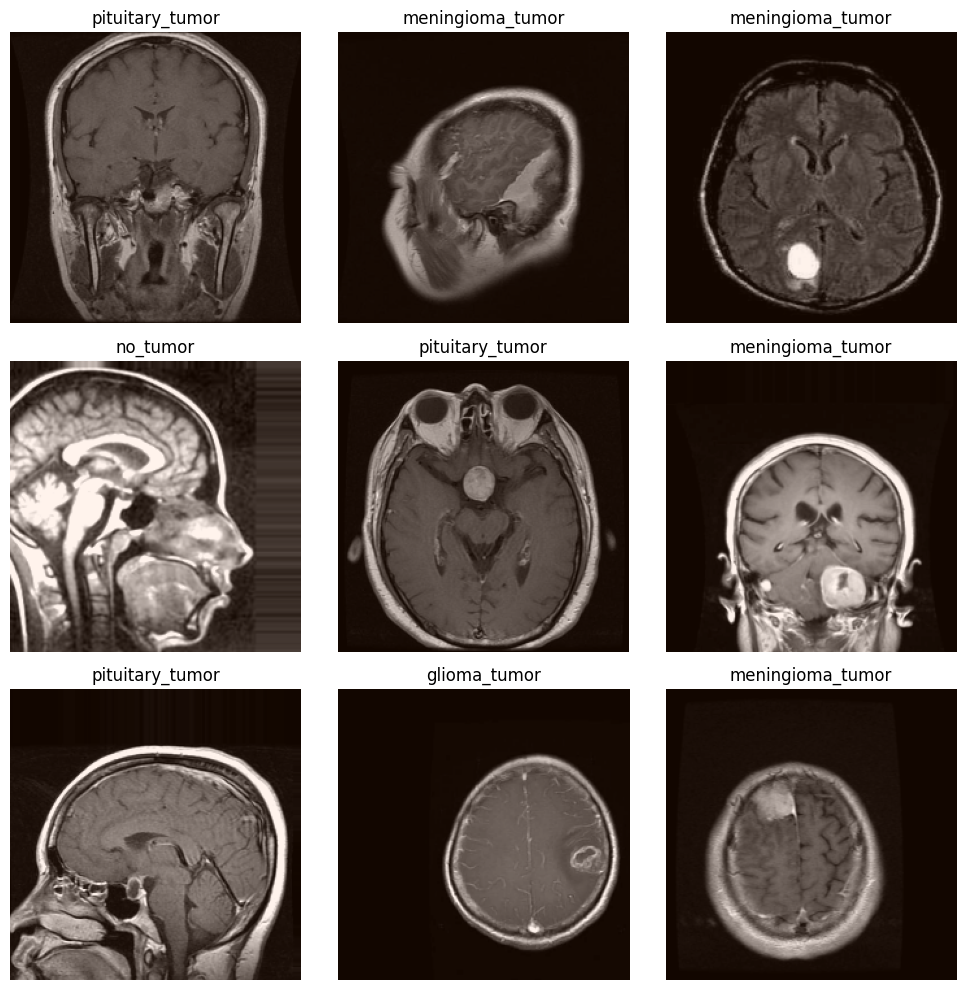

Creando y compilando el modelo VGG16 con el optimizador Adam...


2024-08-10 02:26:41.291204: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-10 02:26:41.291254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-08-10 02:26:41.291257: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-08-10 02:26:41.291286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-10 02:26:41.291304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Optimizador Adam instanciado con éxito.
Callbacks instanciados con éxito.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 14,815,044 (56.51 MB)

 Non-trainable params: 0 (0.00 B)

Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)
Epoch 1/50


2024-08-10 02:26:42.407289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 109s 792ms/step - accuracy: 0.3215 - loss: 6.1679 - val_accuracy: 0.4446 - val_loss: 1.1825 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 108s 797ms/step - accuracy: 0.4463 - loss: 1.1734 - val_accuracy: 0.4564 - val_loss: 1.1629 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 110s 814ms/step - accuracy: 0.5029 - loss: 1.1015 - val_accuracy: 0.4634 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 108s 798ms/step - accuracy: 0.5522 - loss: 1.0085 - val_accuracy: 0.5505 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 106s 785ms/step - accuracy: 0.6002 - loss: 0.9193 - val_accuracy: 0.5944 - val_loss: 0.9103 - learning_rate: 0.0010
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 778ms/step - accuracy: 0.6116 - loss: 0.8939 - val_accuracy: 0.6091 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 774ms/step - accuracy: 0.6672 

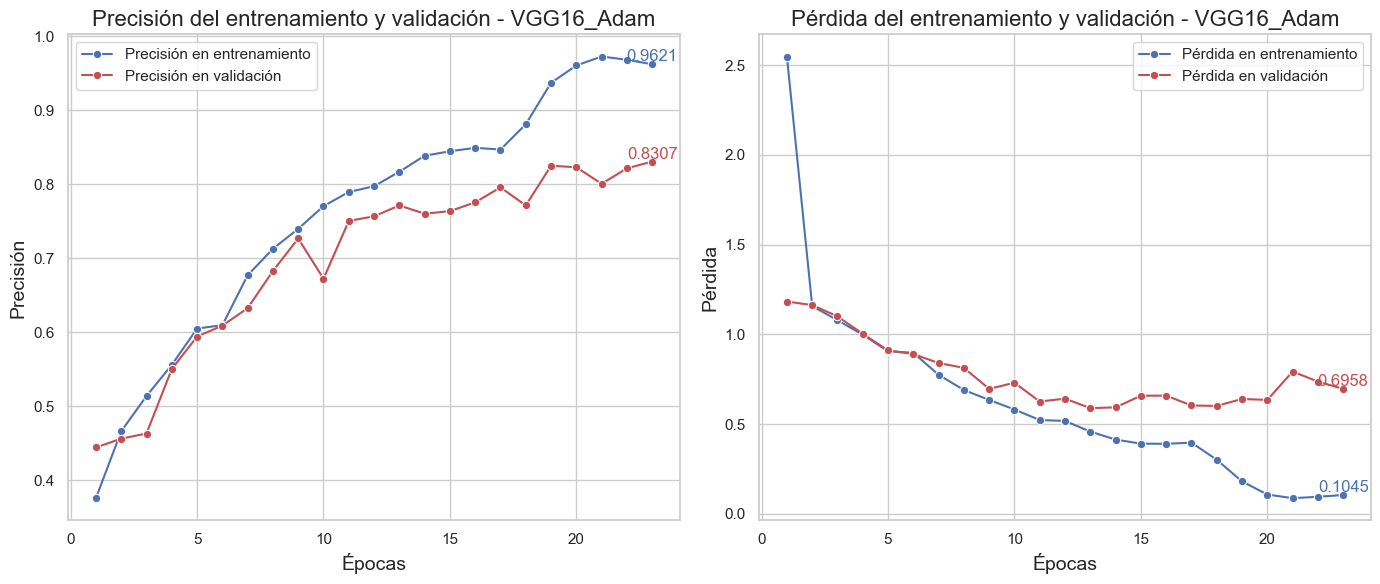

/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.6018 - loss: 3.3425
Test loss: 3.6460258960723877
Test accuracy: 0.5837563276290894
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step


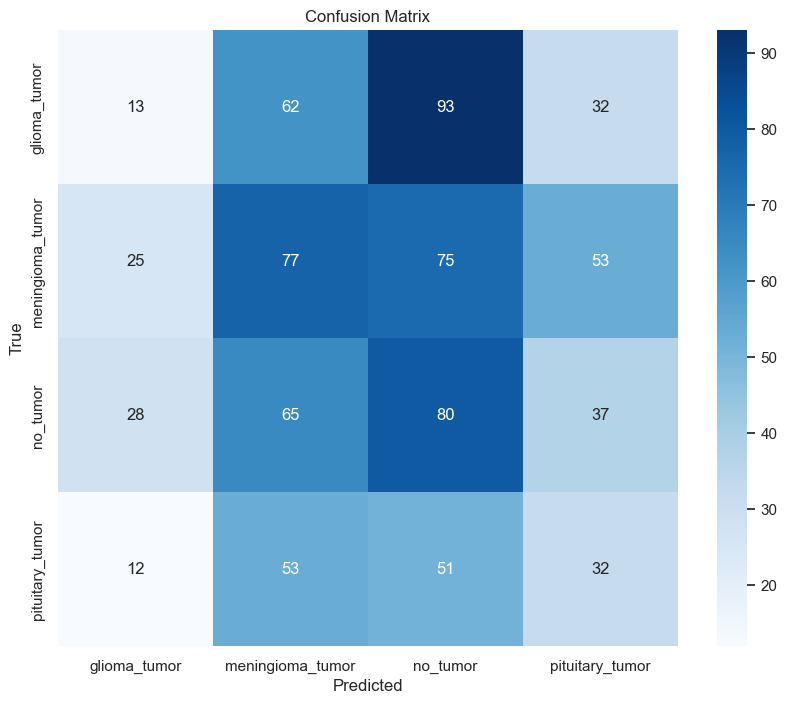

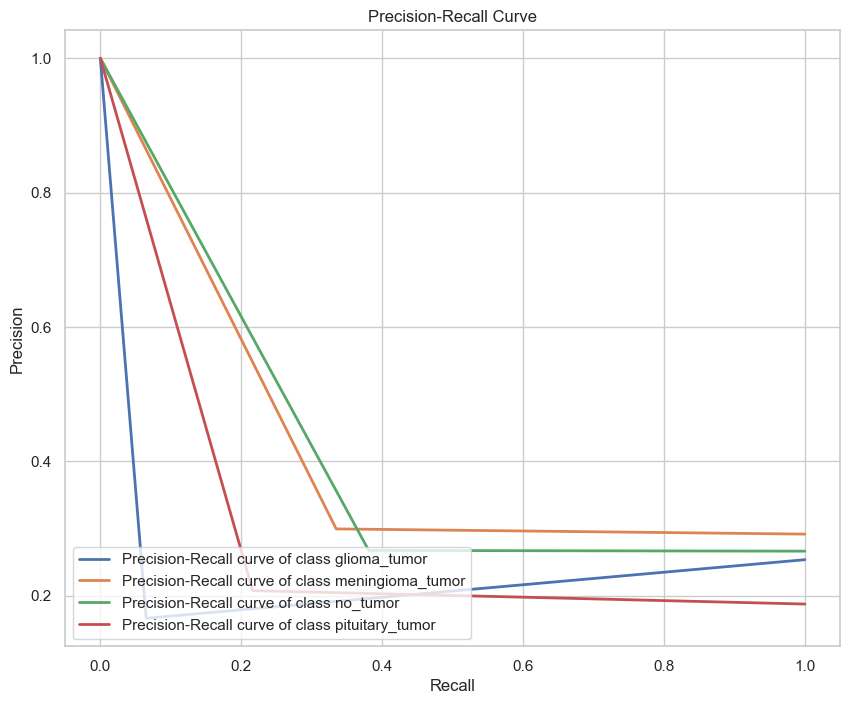

Classification Report for VGG16 with Adam optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       0.17      0.07      0.09       200
meningioma_tumor       0.30      0.33      0.32       230
        no_tumor       0.27      0.38      0.31       210
 pituitary_tumor       0.21      0.22      0.21       148

        accuracy                           0.26       788
       macro avg       0.24      0.25      0.23       788
    weighted avg       0.24      0.26      0.24       788

Usando random seed 74 para el modelo VGG16 con el optimizador RMSprop...
Tamaño del conjunto de entrenamiento: 4305
Tamaño del conjunto de validación: 1435
Generadores de datos creados con éxito.
Visualizando algunas imágenes del conjunto de entrenamiento...


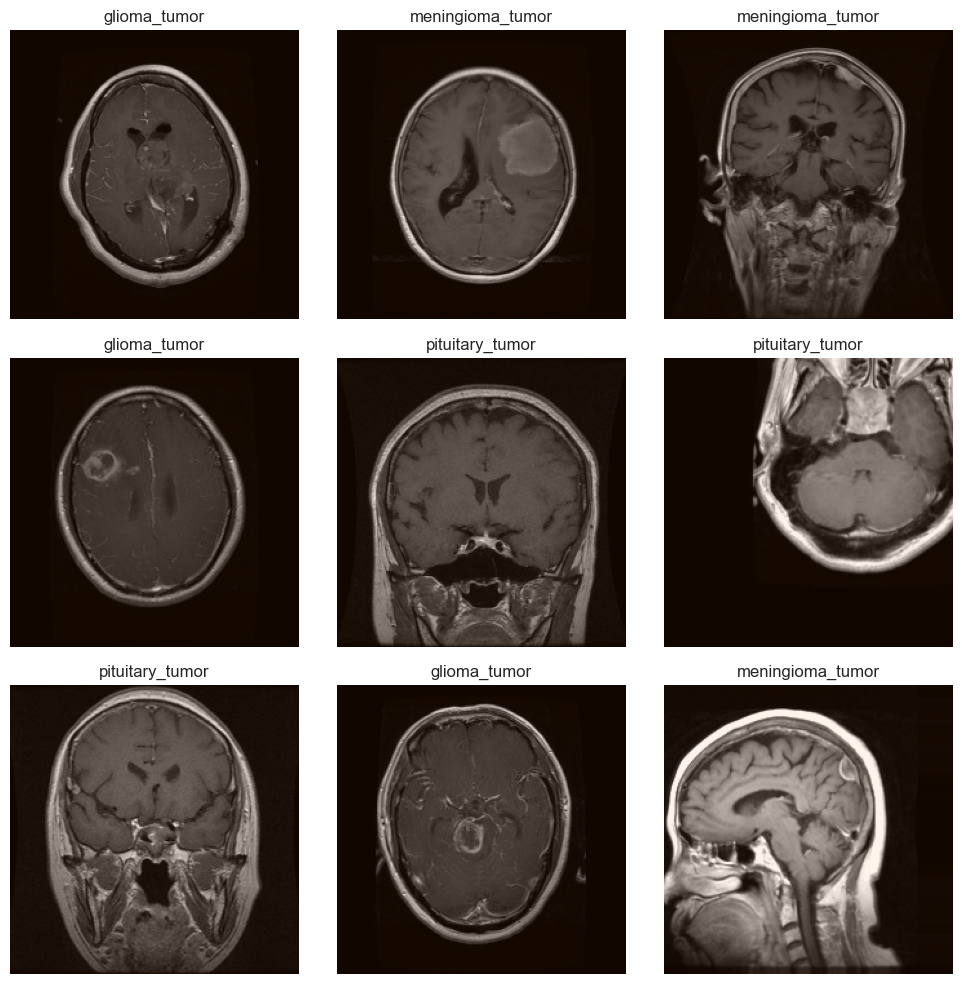

Creando y compilando el modelo VGG16 con el optimizador RMSprop...
Optimizador RMSprop instanciado con éxito.
Callbacks instanciados con éxito.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 14,815,044 (56.51 MB)

 Non-trainable params: 0 (0.00 B)

Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)
Epoch 1/50


/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 107s 785ms/step - accuracy: 0.5108 - loss: 2.4768 - val_accuracy: 0.7707 - val_loss: 0.6023 - learning_rate: 1.0000e-05
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 777ms/step - accuracy: 0.8632 - loss: 0.3745 - val_accuracy: 0.7986 - val_loss: 0.4933 - learning_rate: 1.0000e-05
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 778ms/step - accuracy: 0.9474 - loss: 0.1500 - val_accuracy: 0.8606 - val_loss: 0.3921 - learning_rate: 1.0000e-05
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 779ms/step - accuracy: 0.9827 - loss: 0.0616 - val_accuracy: 0.8732 - val_loss: 0.3810 - learning_rate: 1.0000e-05
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 778ms/step - accuracy: 0.9937 - loss: 0.0239 - val_accuracy: 0.8920 - val_loss: 0.3564 - learning_rate: 1.0000e-05
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 778ms/step - accuracy: 0.9970 - loss: 0.0142 - val_accuracy: 0.8753 - val_loss: 0.4327 - learning_rate: 1.0000e-05
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 106s 785ms/

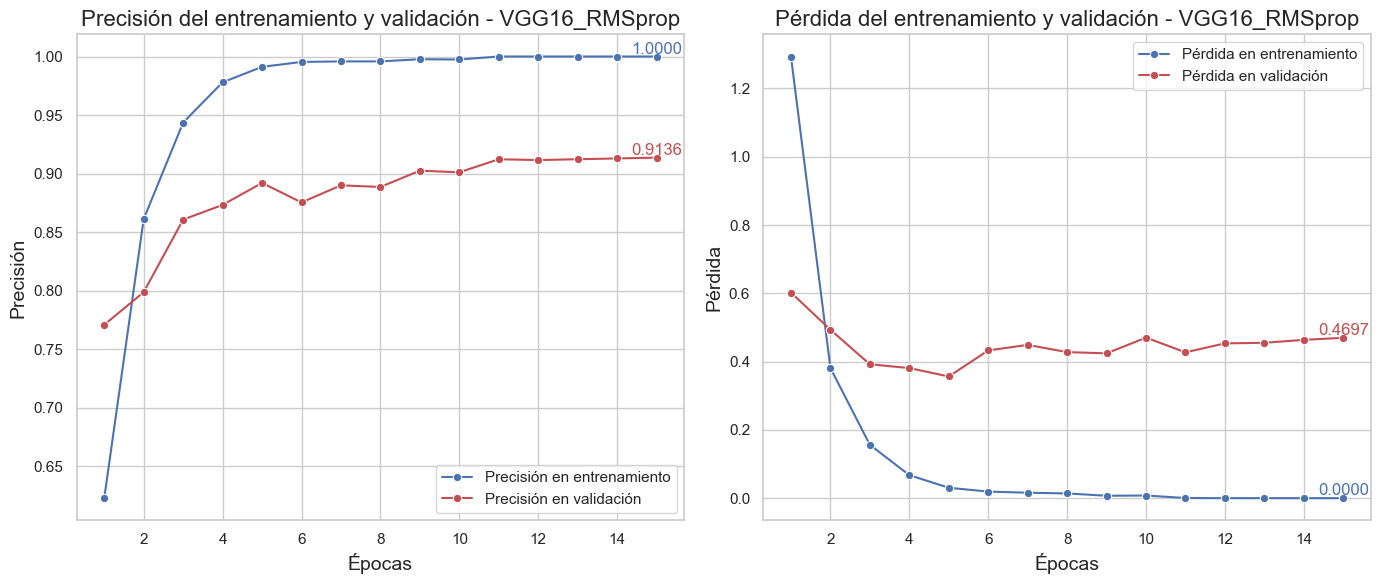

/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7092 - loss: 4.0181
Test loss: 4.186275005340576
Test accuracy: 0.7017766237258911
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step


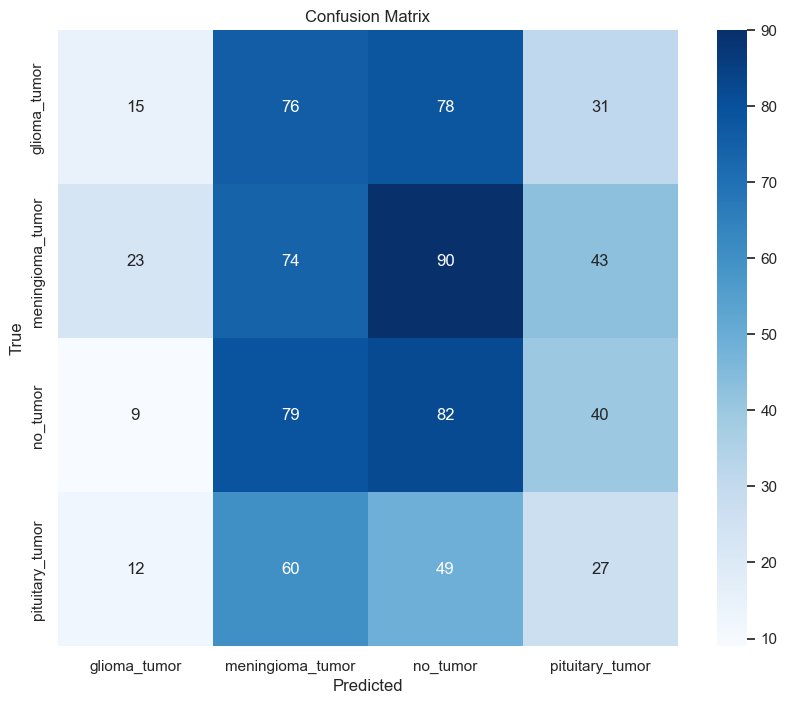

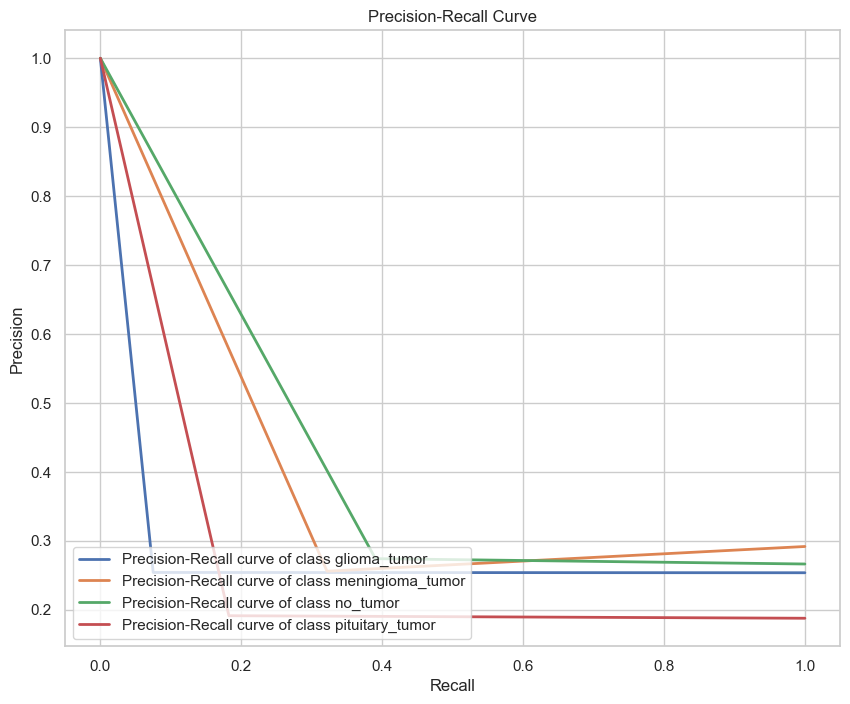

Classification Report for VGG16 with RMSprop optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       0.25      0.07      0.12       200
meningioma_tumor       0.26      0.32      0.29       230
        no_tumor       0.27      0.39      0.32       210
 pituitary_tumor       0.19      0.18      0.19       148

        accuracy                           0.25       788
       macro avg       0.24      0.24      0.23       788
    weighted avg       0.25      0.25      0.23       788

Usando random seed 74 para el modelo ResNet50 con el optimizador Adam...
Tamaño del conjunto de entrenamiento: 4305
Tamaño del conjunto de validación: 1435
Generadores de datos creados con éxito.
Visualizando algunas imágenes del conjunto de entrenamiento...


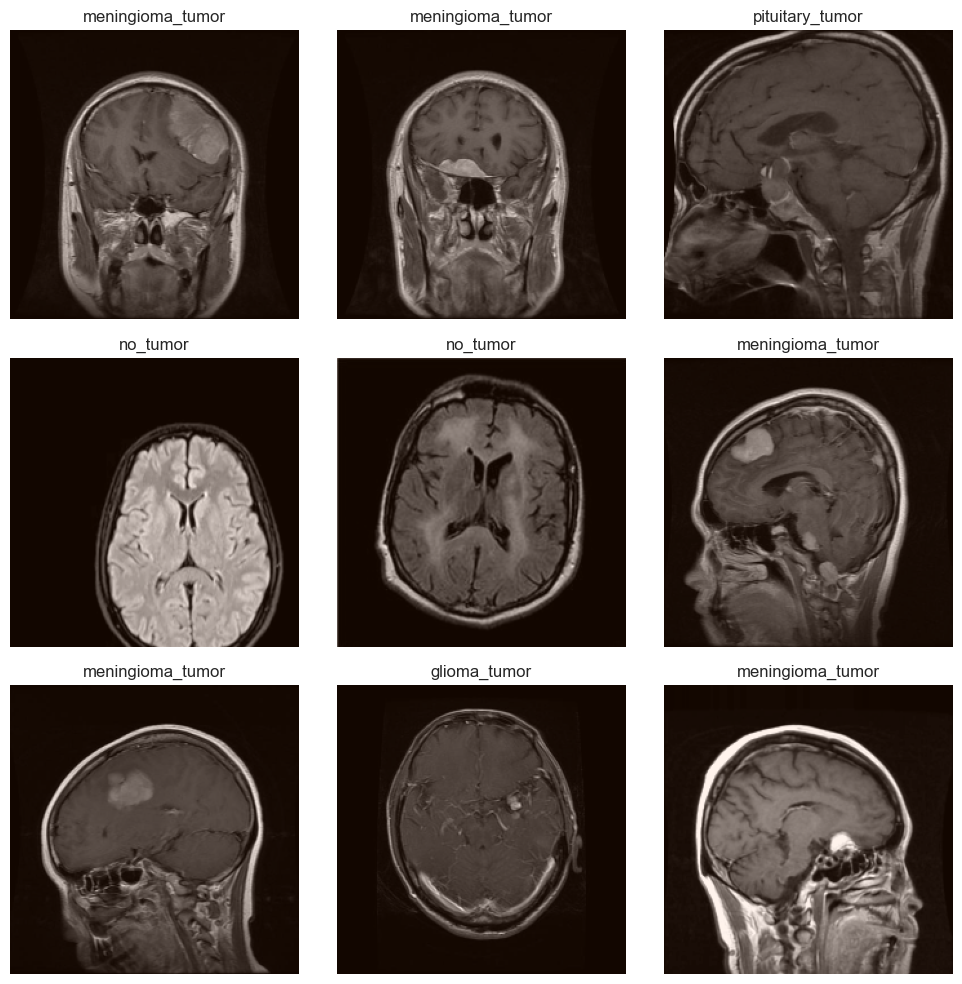

Creando y compilando el modelo ResNet50 con el optimizador Adam...
Optimizador Adam instanciado con éxito.
Callbacks instanciados con éxito.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │       401,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 23,936,004 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)
Epoch 1/50


/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5330 - loss: 1.3813 - val_accuracy: 0.6732 - val_loss: 0.9416 - learning_rate: 1.0000e-05
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9529 - loss: 0.1509 - val_accuracy: 0.7017 - val_loss: 0.8500 - learning_rate: 1.0000e-05
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9963 - loss: 0.0484 - val_accuracy: 0.7087 - val_loss: 0.8153 - learning_rate: 1.0000e-05
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9997 - loss: 0.0229 - val_accuracy: 0.7777 - val_loss: 0.6256 - learning_rate: 1.0000e-05
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 134s 989ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.8418 - val_loss: 0.4626 - learning_rate: 1.0000e-05
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.8530 - val_loss: 0.4021 - learning_rate: 1.0000e-05
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 134s 985ms/step - accuracy

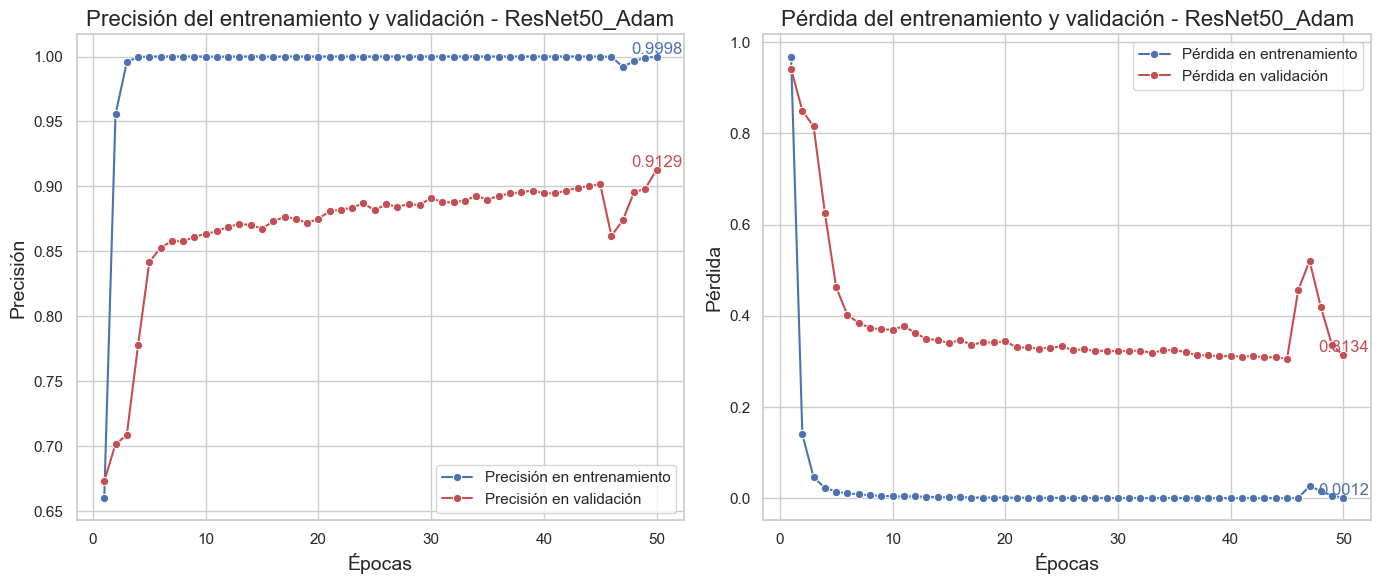

 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.7188 - loss: 2.9132

/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.6909 - loss: 2.4651
Test loss: 2.4088919162750244
Test accuracy: 0.6814720630645752
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step


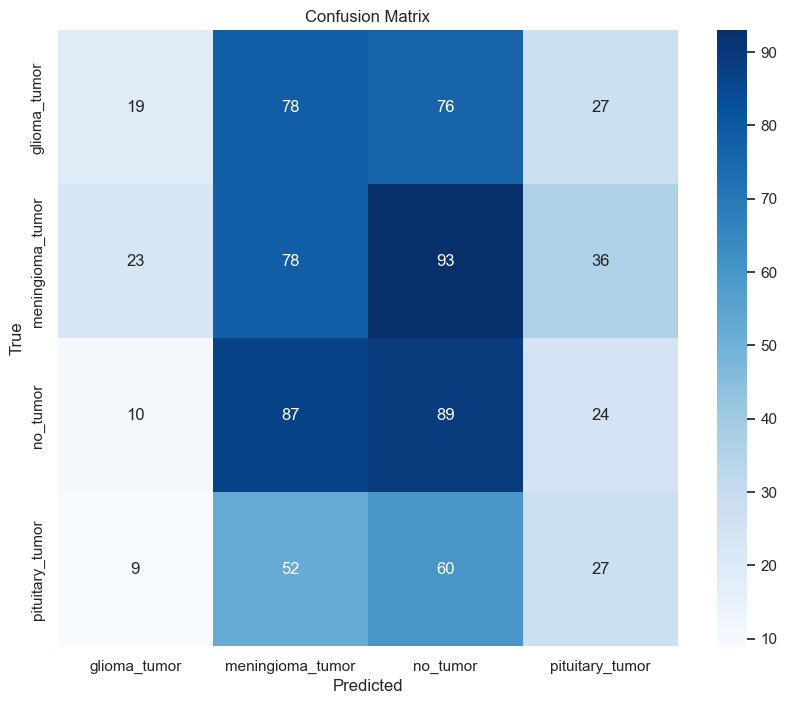

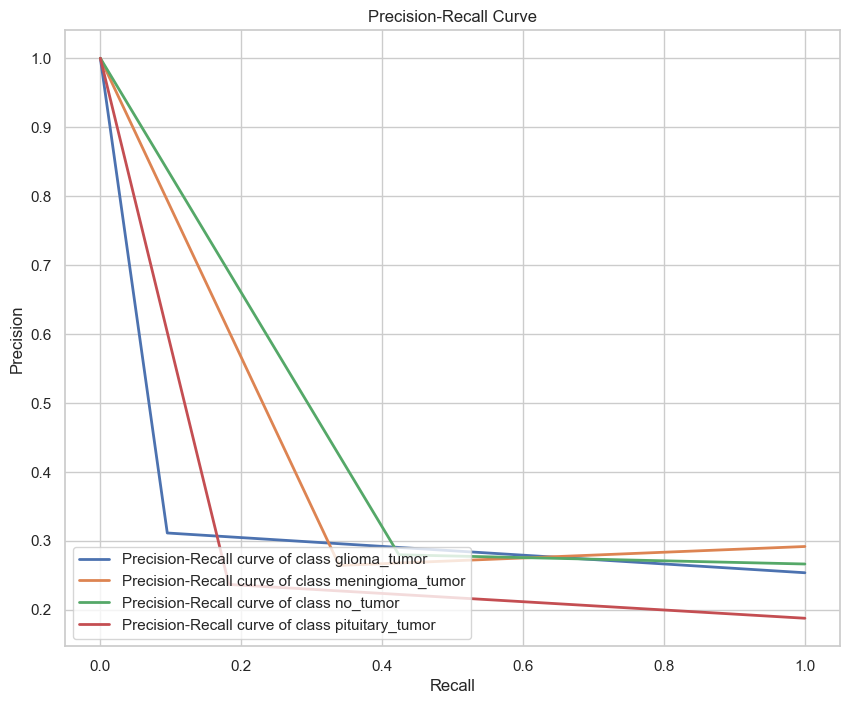

Classification Report for ResNet50 with Adam optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       0.31      0.10      0.15       200
meningioma_tumor       0.26      0.34      0.30       230
        no_tumor       0.28      0.42      0.34       210
 pituitary_tumor       0.24      0.18      0.21       148

        accuracy                           0.27       788
       macro avg       0.27      0.26      0.25       788
    weighted avg       0.28      0.27      0.25       788

Usando random seed 74 para el modelo ResNet50 con el optimizador RMSprop...
Tamaño del conjunto de entrenamiento: 4305
Tamaño del conjunto de validación: 1435
Generadores de datos creados con éxito.
Visualizando algunas imágenes del conjunto de entrenamiento...


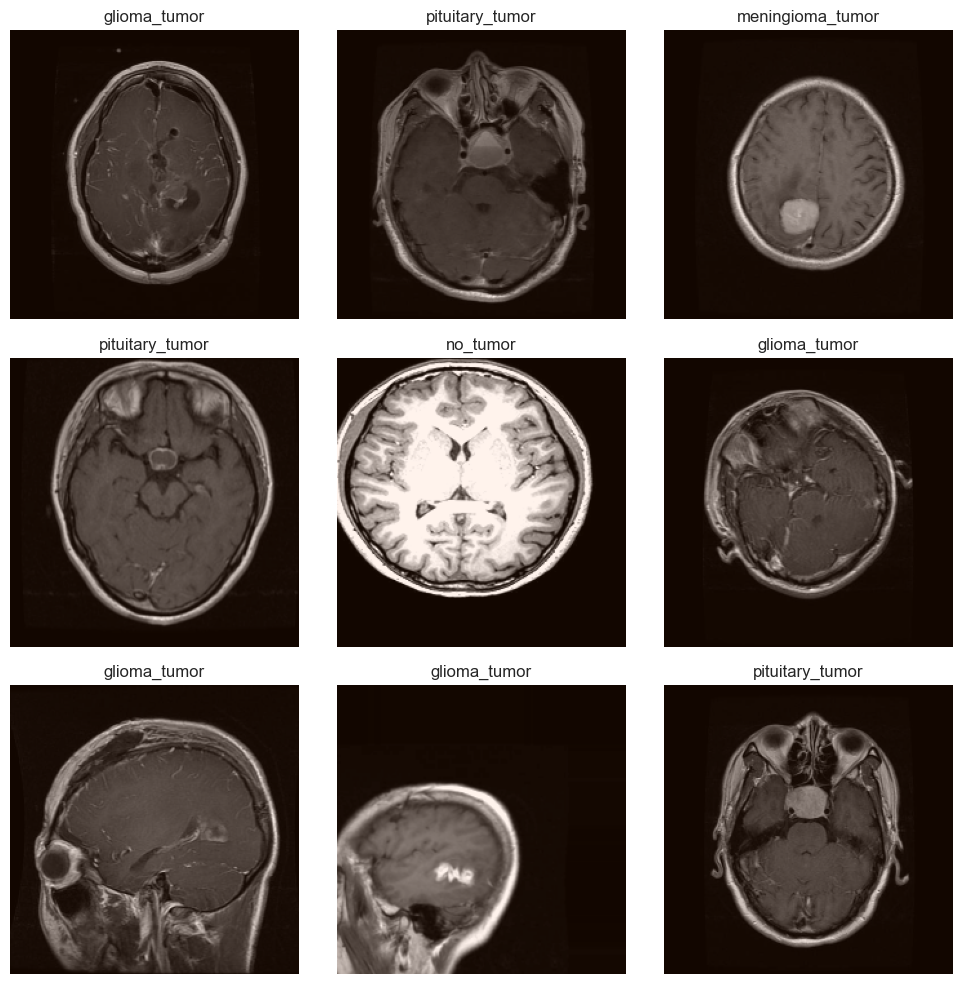

Creando y compilando el modelo ResNet50 con el optimizador RMSprop...
Optimizador RMSprop instanciado con éxito.
Callbacks instanciados con éxito.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │       401,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 23,936,004 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)
Epoch 1/50


/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.5861 - loss: 1.1964 - val_accuracy: 0.5491 - val_loss: 1.6416 - learning_rate: 1.0000e-05
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 126s 929ms/step - accuracy: 0.9618 - loss: 0.1299 - val_accuracy: 0.6014 - val_loss: 1.2841 - learning_rate: 1.0000e-05
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 121s 899ms/step - accuracy: 0.9958 - loss: 0.0277 - val_accuracy: 0.6641 - val_loss: 1.0565 - learning_rate: 1.0000e-05
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 116s 861ms/step - accuracy: 0.9994 - loss: 0.0088 - val_accuracy: 0.7784 - val_loss: 0.6552 - learning_rate: 1.0000e-05
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 125s 926ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8620 - val_loss: 0.4310 - learning_rate: 1.0000e-05
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 127s 941ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8976 - val_loss: 0.3476 - learning_rate: 1.0000e-05
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 123s 910ms/ste

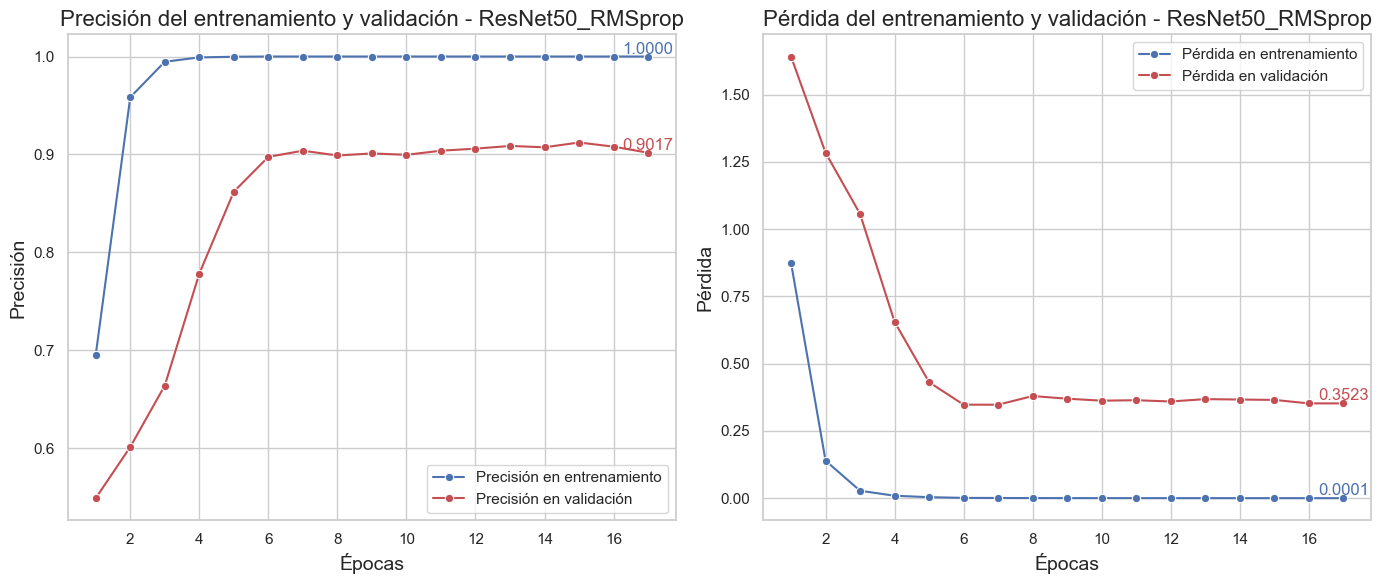

 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5625 - loss: 2.2662

/opt/anaconda3/envs/anaconda_python_3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.7098 - loss: 1.9277
Test loss: 2.1303470134735107
Test accuracy: 0.7017766237258911
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 374ms/step


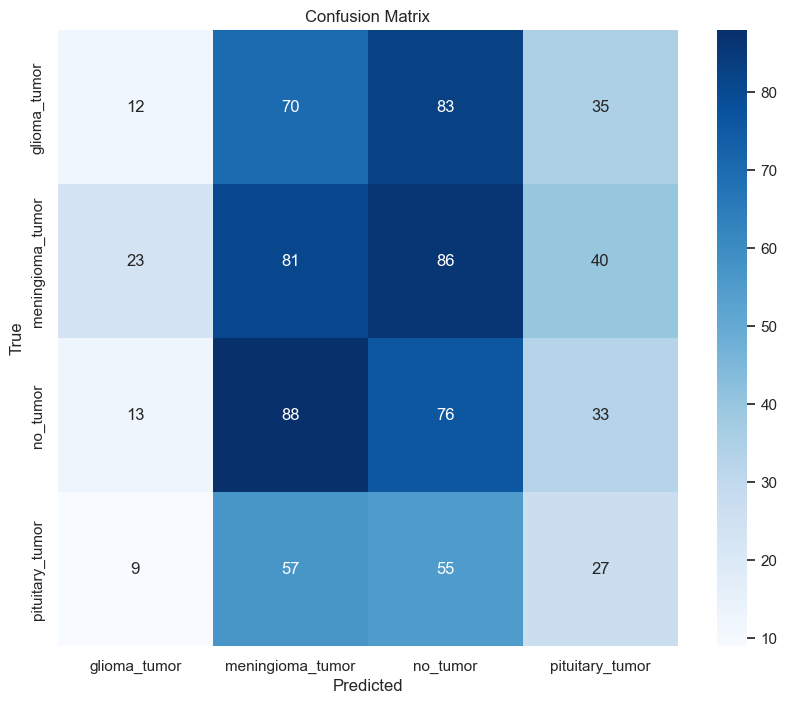

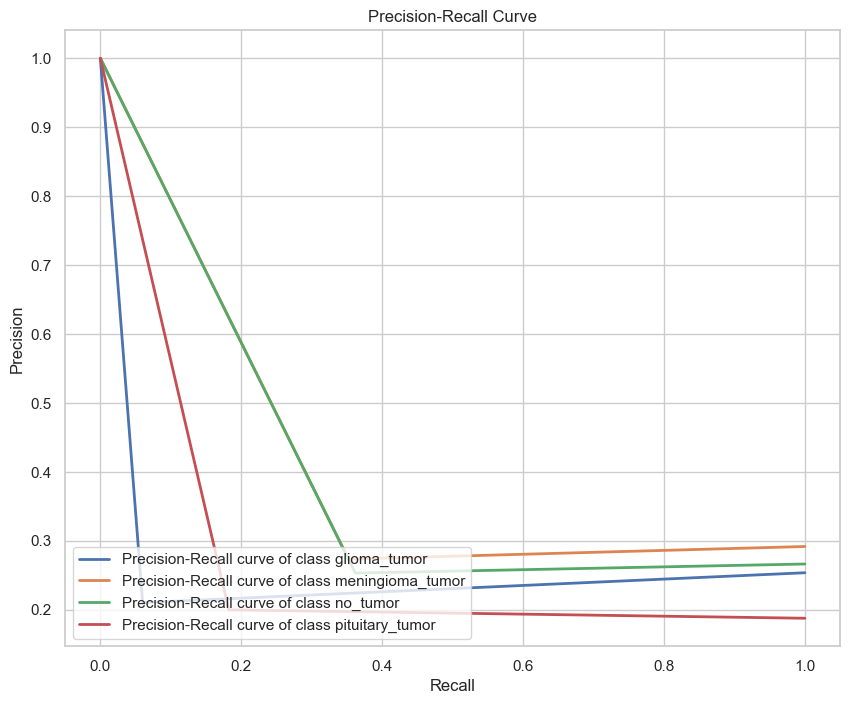

Classification Report for ResNet50 with RMSprop optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       0.21      0.06      0.09       200
meningioma_tumor       0.27      0.35      0.31       230
        no_tumor       0.25      0.36      0.30       210
 pituitary_tumor       0.20      0.18      0.19       148

        accuracy                           0.25       788
       macro avg       0.23      0.24      0.22       788
    weighted avg       0.24      0.25      0.23       788

Usando random seed 74 para el modelo InceptionV3 con el optimizador Adam...


: 

In [20]:
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg

# Definir el número de clases
num_classes = len(np.unique(y_train_combined))
print(f"Number of classes: {num_classes}")

# Diccionario de modelos base y número de capas a descongelar para cada uno
base_model_classes = {
    'VGG16': (VGG16, 5),
    'ResNet50': (ResNet50, 10),
    'InceptionV3': (InceptionV3, 20),
}

optimizer_classes = {
    'Adam': Adam,
    'RMSprop': RMSprop
}

preprocessing_functions = {
    'VGG16': preprocess_vgg,
    'ResNet50': preprocess_resnet,
    'InceptionV3': preprocess_inception,
}


for model_name, (base_model_class, fine_tuning_layers) in base_model_classes.items():
    for opt_name, OptimizerClass in optimizer_classes.items():

        print(f"Usando seed {state_seed} para el modelo {model_name} con el optimizador {opt_name}...")
    
        preprocess_input = preprocessing_functions[model_name]
        X_train_preprocessed = preprocess_input(X_train_combined)
        X_test_preprocessed = preprocess_input(X_test_combined)

        # Dividir el conjunto preprocesado en entrenamiento y validación con una semilla aleatoria distinta
        X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
        X_train_preprocessed, y_train_combined, test_size=0.25, random_state=state_seed, stratify=y_train_combined)

        print(f"Tamaño del conjunto de entrenamiento: {len(X_train_split)}")
        print(f"Tamaño del conjunto de validación: {len(X_valid_split)}")

        # Crear generadores de datos para el conjunto de entrenamiento y validación
        train_generator_split = ImageDataGenerator().flow(X_train_split, y_train_split, batch_size=batch_size)
        validation_generator_split = ImageDataGenerator().flow(X_valid_split, y_valid_split, batch_size=batch_size)
        test_generator = ImageDataGenerator().flow(X_test_preprocessed, y_test_combined, batch_size=batch_size)
        print("Generadores de datos creados con éxito.")

        # Visualizar algunas imágenes del conjunto de entrenamiento
        print("Visualizando algunas imágenes del conjunto de entrenamiento...")
        visualize_images(train_generator_split, CATEGORIES)

        print(f"Creando y compilando el modelo {model_name} con el optimizador {opt_name}...")
        model = create_model(base_model_class, num_classes)

        if opt_name == 'RMSprop':
            learning_rate = 1e-5

        # Crear una nueva instancia del optimizador
        optimizer = OptimizerClass(learning_rate=learning_rate)
        print(f"Optimizador {opt_name} instanciado con éxito.")

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        model_checkpoint = ModelCheckpoint(f'models/{model_name}_{opt_name}_retrained.keras', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        print("Callbacks instanciados con éxito.")

        history = train_model(
            model, train_generator_split, validation_generator_split, epochs=epochs, 
            callbacks=[early_stopping, model_checkpoint, reduce_lr], 
            learning_rate=learning_rate, 
            fine_tuning=True, 
            fine_tuning_layers=fine_tuning_layers,
            optimizer_instance=optimizer,
        )
        print(f"Entrenamiento del modelo {model_name} con el optimizador {opt_name} completado.")

        plot_training_history(history, f"{model_name}_{opt_name}")

        # Evaluar el modelo en el conjunto de pruebas
        scores = model.evaluate(test_generator, verbose=1)
        print('Test loss:', scores[0])
        print('Test accuracy:', scores[1])

        # Predecir las etiquetas para el conjunto de pruebas
        y_pred = model.predict(test_generator, batch_size=batch_size, verbose=1)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Plotear la matriz de confusión
        plot_confusion_matrix(y_test_combined, y_pred_classes, CATEGORIES)

        # Plotear la curva de Precisión vs. Recall
        plot_precision_recall(y_test_combined, y_pred_classes, CATEGORIES)

        # Generar el reporte de clasificación
        class_report = classification_report(y_test_combined, y_pred_classes, target_names=CATEGORIES)
        print(f"Classification Report for {model_name} with {opt_name} optimizer:\n")
        print(class_report)